# [Data] Annotating

### [[Discussion] host - annotation](https://www.kaggle.com/c/siim-covid19-detection/discussion/246597)  

테스트 데이터 세트에 대해서는 label 업데이트. but, train label 은 그대로 유지.  

test data label 은 수정되었으나, train data label 은 시간 제약으로 동일하게 유지되고 업데이트 되지 않았다.  

→ `따라서 연구에 속한 이미지가 2개 이상인 경우, bounding boxes 가 있는 이미지만 사용하는 것을 추천한다.`   

& test data 는 모두 label 이 구성되어있으므로, train data 에서 label 이 없는 이미지를 굳이 학습할 필요가 없다.

bboxes 가 있는 image_level image set + csv 파일만 따로 구성한다.    
image_level 을 위한 것이므로, img_size 는 1024, 512 두 사이즈로 구성    

-> `annotating 이 안된 데이터는 그냥 아예 삭제 -> study_level 에서의 선택권도 주지 않는다?`  
-> study_level image set 에서 아예 빼버린다.


In [1]:
!conda install gdcm -c conda-forge -y

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.9.2
  latest version: 4.10.3

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - gdcm


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    gdcm-2.8.9                 |   py37h5d359c0_2         3.4 MB  conda-forge
    libjpeg-turbo-2.1.0        |       h7f98852_0         987 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         4.4 MB

The following NEW packages will be INSTALLED:

  gdcm               conda-forge/linux-64::gdcm-2.8.9-py37h5d359c0_2
  libjpeg-turbo      conda-forge/linux-64::libjpeg-turbo-2.1.0-h7f98852_0



gdcm-2.8.9           | 3.4 MB    | ##################################### | 100% 
libj

In [53]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pydicom
from pydicom import dcmread
from pydicom.pixel_data_handlers.util import apply_voi_lut
from tqdm import tqdm
import cv2
import ast
from glob import glob
from PIL import Image
from warnings import filterwarnings
filterwarnings('ignore')

In [3]:
def read_xray(path, voi_lut = True, fix_monochrome = True):
    # Original from: https://www.kaggle.com/raddar/convert-dicom-to-np-array-the-correct-way
    dicom = pydicom.read_file(path)
    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to 
    # "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == 'MONOCHROME1':
        data = np.amax(data) - data
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return data

def resize(array, size, keep_ratio=False, resample=Image.LANCZOS):
    # Original from: https://www.kaggle.com/xhlulu/vinbigdata-process-and-resize-to-image
    im = Image.fromarray(array)
    if keep_ratio:
        im.thumnail((size, size), resample)
    else:
        im = im.resize((size, size), resample)
    return im

### Image_level 에 대해서만 수행 w/ study_level 중 여러개 있는 데이터에 대해서만 수행

In [4]:
train_study = pd.read_csv("../input/siim-covid19-detection/train_study_level.csv")
train_image = pd.read_csv("../input/siim-covid19-detection/train_image_level.csv")
train_study.shape, train_image.shape

((6054, 5), (6334, 4))

In [5]:
display(train_study.head(), train_image.head())

,id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,00086460a852_study,0,1,0,0
1,000c9c05fd14_study,0,0,0,1
2,00292f8c37bd_study,1,0,0,0
3,005057b3f880_study,1,0,0,0
4,0051d9b12e72_study,0,0,0,1


,id,boxes,label,StudyInstanceUID
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e


In [6]:
tmp = train_image[train_image['boxes'].isnull()]
tmp = tmp['StudyInstanceUID'].apply(lambda x: x + '_study').to_list()
len(tmp)

2040

In [7]:
tmp_study = train_study[train_study['id'].isin(tmp)]
tmp_study

,id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
1,000c9c05fd14_study,0,0,0,1
2,00292f8c37bd_study,1,0,0,0
3,005057b3f880_study,1,0,0,0
5,00792b5c8852_study,1,0,0,0
6,00908ffd2d08_study,1,0,0,0
...,...,...,...,...,...
6032,ff0879eb20ed_study,1,0,0,0
6034,ff19b8e99b4b_study,1,0,0,0
6043,ff7ffd9c6c80_study,1,0,0,0
6045,ff9f78aa56a3_study,1,0,0,0


In [8]:
for col in tmp_study.columns[1:]:
    print(f"{col} : {tmp_study[col].sum()}")
# box 가 존재하지 않는 study_level 의 label 분포

Negative for Pneumonia : 1676
Typical Appearance : 131
Indeterminate Appearance : 42
Atypical Appearance : 88


In [9]:
tmp = train_study[train_study['id'].isin(tmp)]

In [10]:
multi_lst = train_image[train_image['StudyInstanceUID'].duplicated() == True]['StudyInstanceUID'].unique()
print(f"2개 이상 이미지를 갖고 있는 studyID 의 갯수 : {len(multi_lst)}")

2개 이상 이미지를 갖고 있는 studyID 의 갯수 : 232


In [11]:
multi_df = train_image[train_image['StudyInstanceUID'].isin(multi_lst)]
multi_df

,id,boxes,label,StudyInstanceUID
22,00c1515729a8_image,NaN,none 1 0 0 1 1,1a58b43cf286
24,00e3a7e91a34_image,NaN,none 1 0 0 1 1,74ba8f2badcb
27,0102b5cac730_image,NaN,none 1 0 0 1 1,81f6b4b343f7
123,04a0b90d7875_image,NaN,none 1 0 0 1 1,effcdb73627e
130,04cc2f7f4c4b_image,NaN,none 1 0 0 1 1,0fd2db233deb
...,...,...,...,...
6191,fa447a409bd6_image,"[{'x': 358.73684, 'y': 483.5904, 'width': 1141...",opacity 1 358.73684 483.5904 1500.172230000000...,76b5e2db22ba
6194,fa5e3f933004_image,NaN,none 1 0 0 1 1,abd0c3d9c5f6
6210,fb1e24bf6698_image,NaN,none 1 0 0 1 1,2edd69dd0934
6217,fb67948ac1f1_image,NaN,none 1 0 0 1 1,350cd603e64d


In [12]:
multi_df['StudyInstanceUID'].value_counts().to_frame('count')['count'].value_counts()

2    207
3     15
4      4
5      3
6      1
7      1
9      1
Name: count, dtype: int64

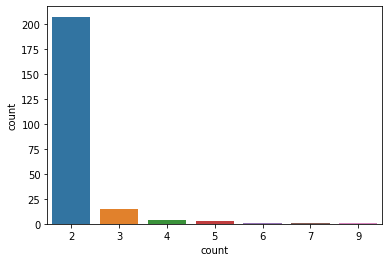

In [13]:
sns.countplot(multi_df['StudyInstanceUID'].value_counts().to_frame('count')['count']);

In [14]:
multi_df2 = multi_df.sort_values(by=['StudyInstanceUID']).reset_index()
multi_df2.rename(columns = {"index":"number"}, inplace=True)
multi_df2

,number,id,boxes,label,StudyInstanceUID
0,2862,74077a8e3b7c_image,"[{'x': 2175.24285, 'y': 1123.72368, 'width': 4...",opacity 1 2175.24285 1123.72368 2607.50603 162...,00f9e183938e
1,2490,6534a837497d_image,NaN,none 1 0 0 1 1,00f9e183938e
2,2119,55e22c0c5de0_image,"[{'x': 455.99999, 'y': 1480.00008, 'width': 26...",opacity 1 455.99999 1480.00008 722.39998 2437....,0142feaef82f
3,6061,f5451a98d684_image,NaN,none 1 0 0 1 1,0142feaef82f
4,3880,9e4824fcee2e_image,"[{'x': 817.77961, 'y': 1075.34501, 'width': 64...",opacity 1 817.77961 1075.34501 1467.08961 2075...,0369e0385796
...,...,...,...,...,...
507,1600,4123a71d9796_image,"[{'x': 889.45144, 'y': 282.39441, 'width': 825...",opacity 1 889.45144 282.39441 1714.51125 1585....,fc45007f145a
508,827,218bcf950372_image,NaN,none 1 0 0 1 1,fd92c6f2b2e6
509,5735,e6cc65d9de1d_image,NaN,none 1 0 0 1 1,fd92c6f2b2e6
510,3277,84ed5f7f71bf_image,"[{'x': 1721.27651, 'y': 974.09667, 'width': 12...",opacity 1 1721.27651 974.09667 2999.21998 2681...,ffcb4630f46f


In [15]:
# 두개로 나누기 : box 가 존재하는 id, 모두 NaN 인 id
is_box = multi_df2[multi_df2['boxes'].isnull() == False]['StudyInstanceUID'].to_list()
all_nan = [x for x in multi_lst if x not in is_box]
print(f"box 가 있는 id 갯수 : {len(is_box)}")
print(f"box 가 없는 id 갯수 : {len(all_nan)}")
print(f"Total id 갯수 : {len(all_nan) + len(is_box)}")
print(f"본래 multi_lst 갯수 : {len(multi_lst)}")

box 가 있는 id 갯수 : 177
box 가 없는 id 갯수 : 55
Total id 갯수 : 232
본래 multi_lst 갯수 : 232


In [16]:
# box 있는 id 만 모아놓은 df
box_df = multi_df2[multi_df2['StudyInstanceUID'].isin(is_box)]
box_df

,number,id,boxes,label,StudyInstanceUID
0,2862,74077a8e3b7c_image,"[{'x': 2175.24285, 'y': 1123.72368, 'width': 4...",opacity 1 2175.24285 1123.72368 2607.50603 162...,00f9e183938e
1,2490,6534a837497d_image,NaN,none 1 0 0 1 1,00f9e183938e
2,2119,55e22c0c5de0_image,"[{'x': 455.99999, 'y': 1480.00008, 'width': 26...",opacity 1 455.99999 1480.00008 722.39998 2437....,0142feaef82f
3,6061,f5451a98d684_image,NaN,none 1 0 0 1 1,0142feaef82f
4,3880,9e4824fcee2e_image,"[{'x': 817.77961, 'y': 1075.34501, 'width': 64...",opacity 1 817.77961 1075.34501 1467.08961 2075...,0369e0385796
...,...,...,...,...,...
505,4570,ba375ad92c5f_image,NaN,none 1 0 0 1 1,fae06a05819a
506,3392,8a38c00672d5_image,NaN,none 1 0 0 1 1,fc45007f145a
507,1600,4123a71d9796_image,"[{'x': 889.45144, 'y': 282.39441, 'width': 825...",opacity 1 889.45144 282.39441 1714.51125 1585....,fc45007f145a
510,3277,84ed5f7f71bf_image,"[{'x': 1721.27651, 'y': 974.09667, 'width': 12...",opacity 1 1721.27651 974.09667 2999.21998 2681...,ffcb4630f46f


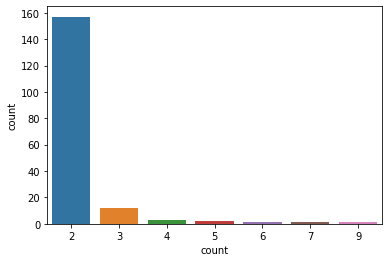

In [17]:
# box 를 보유한 study 들의 image 갯수 비율
sns.countplot(box_df['StudyInstanceUID'].value_counts().to_frame('count')['count']);

In [18]:
# 2개 이상일 경우, box 가 존재하는 이미지, 존재하지 않는 이미지 사이에 차이가 있는지 확인해보자 -> check for study_level experiment
check_box = box_df['StudyInstanceUID'].unique()

check = False

if check:
    train_path = '../input/siim-covid19-detection/train/'

    fig, axes = plt.subplots(len(check_box),2,figsize=(12,5 * len(check_box)))

    for i, study_id in tqdm(enumerate(check_box), total = len(check_box)): # len = 177
        i *= 2
        for dirname, _, filenames in os.walk(train_path + study_id):
            for file in filenames:
                xray = read_xray(os.path.join(dirname, file))
                im = resize(xray, size = 512)
                if im:
                    axes[i//2][i%2].imshow(im)
                    axes[i//2][i%2].set_title(f"{study_id} : {file}")
                    i += 1
    plt.show();

check_box 실행 결과, 이미지 간에 차이가 있긴 하다.(큰 차이는 아니므로 일단 놔두자)    
study_level 예측을 할 때, 어떤 클래스를 제대로 예측하는지, 못하는지 label 별로 확인해보자.  
val.predict -> 클래스별 metric, loss 비교    
vinbigdata solution 에서는, 잘 학습하지 못하는 class 를 보완을 했었는데, 그 부분을 찾아보고 어떻게 보완하면 좋을지 생각해보자.  


In [19]:
trash = box_df[box_df['boxes'].isnull()] # box 가 있는 study_level 중 box 가 없는 image 들
trash

,number,id,boxes,label,StudyInstanceUID
1,2490,6534a837497d_image,NaN,none 1 0 0 1 1,00f9e183938e
3,6061,f5451a98d684_image,NaN,none 1 0 0 1 1,0142feaef82f
5,5807,ea2117b53323_image,NaN,none 1 0 0 1 1,0369e0385796
7,1878,4cf41c062d0c_image,NaN,none 1 0 0 1 1,061d2ddaddd1
8,5909,eea3a910fa9e_image,NaN,none 1 0 0 1 1,066b12d875eb
...,...,...,...,...,...
501,3908,9f50edab452b_image,NaN,none 1 0 0 1 1,f74f0c0db300
502,3606,91f72df96e13_image,NaN,none 1 0 0 1 1,fa9ea207e240
505,4570,ba375ad92c5f_image,NaN,none 1 0 0 1 1,fae06a05819a
506,3392,8a38c00672d5_image,NaN,none 1 0 0 1 1,fc45007f145a


In [20]:
trash_number = trash['number'].to_list()
print(f"버릴 데이터들 index 갯수 : {len(trash_number)}")

버릴 데이터들 index 갯수 : 217


In [21]:
all_nan_df = multi_df2[multi_df2['StudyInstanceUID'].isin(all_nan)]
all_nan_df

,number,id,boxes,label,StudyInstanceUID
22,4447,b61f3493c551_image,NaN,none 1 0 0 1 1,0d962bb4c9f2
23,227,089bd77c8c10_image,NaN,none 1 0 0 1 1,0d962bb4c9f2
24,214,0842f032a217_image,NaN,none 1 0 0 1 1,0d9709b3af74
25,5933,efc93a3917b6_image,NaN,none 1 0 0 1 1,0d9709b3af74
26,3232,830063223a31_image,NaN,none 1 0 0 1 1,0d9709b3af74
...,...,...,...,...,...
489,701,1c1069c57757_image,NaN,none 1 0 0 1 1,f2b77c3c70c5
498,822,21518ca15050_image,NaN,none 1 0 0 1 1,f6ffe212deeb
499,584,173c23887f9b_image,NaN,none 1 0 0 1 1,f6ffe212deeb
508,827,218bcf950372_image,NaN,none 1 0 0 1 1,fd92c6f2b2e6


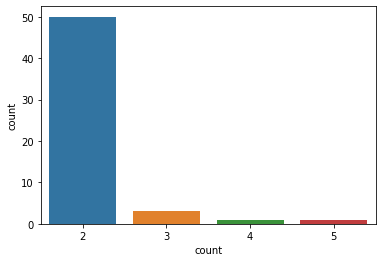

In [22]:
# box 를 보유하지 않은 study 들의 image 갯수 비율
sns.countplot(all_nan_df['StudyInstanceUID'].value_counts().to_frame('count')['count']);

In [23]:
all_nan_df['StudyInstanceUID'].nunique()

55

In [24]:
all_nan_df

,number,id,boxes,label,StudyInstanceUID
22,4447,b61f3493c551_image,NaN,none 1 0 0 1 1,0d962bb4c9f2
23,227,089bd77c8c10_image,NaN,none 1 0 0 1 1,0d962bb4c9f2
24,214,0842f032a217_image,NaN,none 1 0 0 1 1,0d9709b3af74
25,5933,efc93a3917b6_image,NaN,none 1 0 0 1 1,0d9709b3af74
26,3232,830063223a31_image,NaN,none 1 0 0 1 1,0d9709b3af74
...,...,...,...,...,...
489,701,1c1069c57757_image,NaN,none 1 0 0 1 1,f2b77c3c70c5
498,822,21518ca15050_image,NaN,none 1 0 0 1 1,f6ffe212deeb
499,584,173c23887f9b_image,NaN,none 1 0 0 1 1,f6ffe212deeb
508,827,218bcf950372_image,NaN,none 1 0 0 1 1,fd92c6f2b2e6


In [25]:
df_count = all_nan_df['StudyInstanceUID'].value_counts().to_frame('count').reset_index()
df_count.rename(columns={'index':'StudyInstanceUID'}, inplace=True)
all_nan_df2 = pd.merge(all_nan_df, df_count, how='left', on='StudyInstanceUID')
all_nan_df2

,number,id,boxes,label,StudyInstanceUID,count
0,4447,b61f3493c551_image,NaN,none 1 0 0 1 1,0d962bb4c9f2,2
1,227,089bd77c8c10_image,NaN,none 1 0 0 1 1,0d962bb4c9f2,2
2,214,0842f032a217_image,NaN,none 1 0 0 1 1,0d9709b3af74,3
3,5933,efc93a3917b6_image,NaN,none 1 0 0 1 1,0d9709b3af74,3
4,3232,830063223a31_image,NaN,none 1 0 0 1 1,0d9709b3af74,3
...,...,...,...,...,...,...
113,701,1c1069c57757_image,NaN,none 1 0 0 1 1,f2b77c3c70c5,2
114,822,21518ca15050_image,NaN,none 1 0 0 1 1,f6ffe212deeb,2
115,584,173c23887f9b_image,NaN,none 1 0 0 1 1,f6ffe212deeb,2
116,827,218bcf950372_image,NaN,none 1 0 0 1 1,fd92c6f2b2e6,2


In [26]:
two = all_nan_df2[all_nan_df2['count'] == 2]
other = all_nan_df2[all_nan_df2['count'] != 2]
display(two, other)

,number,id,boxes,label,StudyInstanceUID,count
0,4447,b61f3493c551_image,NaN,none 1 0 0 1 1,0d962bb4c9f2,2
1,227,089bd77c8c10_image,NaN,none 1 0 0 1 1,0d962bb4c9f2,2
5,490,12e97ed89297_image,NaN,none 1 0 0 1 1,2651f80c25b1,2
6,5192,d180fed57716_image,NaN,none 1 0 0 1 1,2651f80c25b1,2
7,1415,395e9f2c003d_image,NaN,none 1 0 0 1 1,29afa03eedd3,2
...,...,...,...,...,...,...
113,701,1c1069c57757_image,NaN,none 1 0 0 1 1,f2b77c3c70c5,2
114,822,21518ca15050_image,NaN,none 1 0 0 1 1,f6ffe212deeb,2
115,584,173c23887f9b_image,NaN,none 1 0 0 1 1,f6ffe212deeb,2
116,827,218bcf950372_image,NaN,none 1 0 0 1 1,fd92c6f2b2e6,2


,number,id,boxes,label,StudyInstanceUID,count
2,214,0842f032a217_image,NaN,none 1 0 0 1 1,0d9709b3af74,3
3,5933,efc93a3917b6_image,NaN,none 1 0 0 1 1,0d9709b3af74,3
4,3232,830063223a31_image,NaN,none 1 0 0 1 1,0d9709b3af74,3
45,2402,61e618dc7f9a_image,NaN,none 1 0 0 1 1,7416b5cbc531,3
46,4418,b48682a34cfe_image,NaN,none 1 0 0 1 1,7416b5cbc531,3
47,2577,6861c5992717_image,NaN,none 1 0 0 1 1,7416b5cbc531,3
48,3649,93a881fb3292_image,NaN,none 1 0 0 1 1,74ba8f2badcb,4
49,5093,cdd9e3aaf45a_image,NaN,none 1 0 0 1 1,74ba8f2badcb,4
50,24,00e3a7e91a34_image,NaN,none 1 0 0 1 1,74ba8f2badcb,4
51,346,0d4d6acc9ed3_image,NaN,none 1 0 0 1 1,74ba8f2badcb,4


### none 으로만 구성된 데이터 중 study 내에 이미지가 2개 인 것들만

In [27]:
two_image = False

if two_image:
    train_path = '../input/siim-covid19-detection/train/'

    fig, axes = plt.subplots(50,2,figsize=(12,250))

    tmp = two['StudyInstanceUID'].unique()
    for i, study_id in tqdm(enumerate(tmp), total = len(tmp)): # len = 50
        i *= 2
        for dirname, _, filenames in os.walk(train_path + study_id):
            for file in filenames:
                xray = read_xray(os.path.join(dirname, file))
                im = resize(xray, size = 512)
                if im:
                    axes[i//2][i%2].imshow(im)
                    axes[i//2][i%2].set_title(f"{study_id} : {file}")
                    i += 1
    plt.show();

### none 으로만 구성된 데이터 중 study 내에 이미지가 3개 이상인 것들만(3,4,5개 로 구성됨)

In [28]:
other

,number,id,boxes,label,StudyInstanceUID,count
2,214,0842f032a217_image,NaN,none 1 0 0 1 1,0d9709b3af74,3
3,5933,efc93a3917b6_image,NaN,none 1 0 0 1 1,0d9709b3af74,3
4,3232,830063223a31_image,NaN,none 1 0 0 1 1,0d9709b3af74,3
45,2402,61e618dc7f9a_image,NaN,none 1 0 0 1 1,7416b5cbc531,3
46,4418,b48682a34cfe_image,NaN,none 1 0 0 1 1,7416b5cbc531,3
47,2577,6861c5992717_image,NaN,none 1 0 0 1 1,7416b5cbc531,3
48,3649,93a881fb3292_image,NaN,none 1 0 0 1 1,74ba8f2badcb,4
49,5093,cdd9e3aaf45a_image,NaN,none 1 0 0 1 1,74ba8f2badcb,4
50,24,00e3a7e91a34_image,NaN,none 1 0 0 1 1,74ba8f2badcb,4
51,346,0d4d6acc9ed3_image,NaN,none 1 0 0 1 1,74ba8f2badcb,4


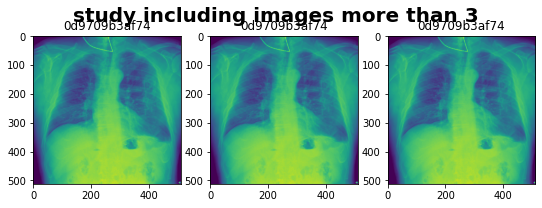

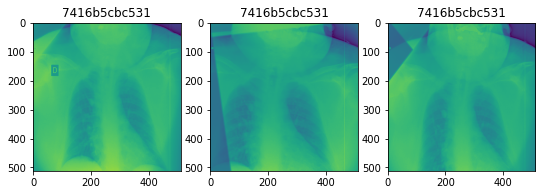

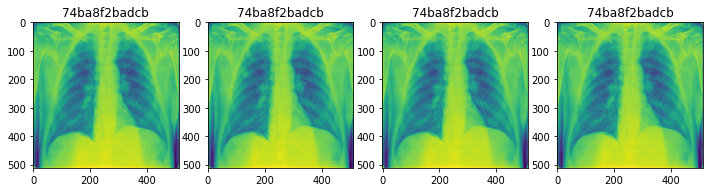

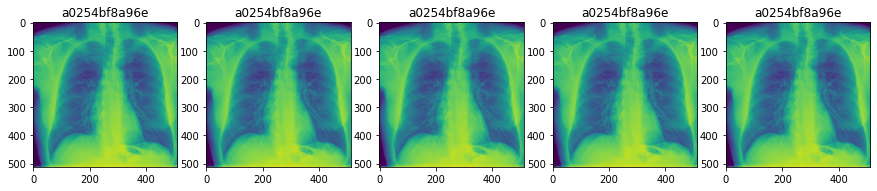

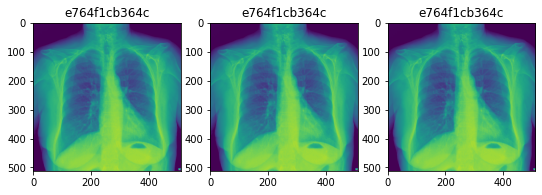

In [29]:
train_path = '../input/siim-covid19-detection/train/'


title = True
for study_id in other['StudyInstanceUID'].unique():
    tmp = other[other['StudyInstanceUID'] == study_id]
    tmp_count = tmp.shape[0]
    fig, axes = plt.subplots(1, tmp_count, figsize=(tmp_count * 3,3))
    if title:
        plt.suptitle(f"study including images more than 3", fontsize=20, weight='bold')
        title = False
    i = -1
    for dirname, _, filenames in os.walk(train_path + study_id):
        for file in filenames:
            xray = read_xray(os.path.join(dirname, file))
            im = resize(xray, size = 512)
            if im:
                i += 1
                axes[i%tmp_count].imshow(im)
                axes[i%tmp_count].set_title(f"{study_id}")
plt.show();

None 만 보유하고 있는 study 데이터 중 3개 이상을 보유한 이미지들은 모두 비슷한 이미지이므로, 그대로 사용해도 문제가 없겠다.  

즉, 데이터를 정리하자면,  
study_level 중 image 를 `1개 보유`, `2개 이상 이미지를 포함하는 study 중 box 를 포함한 case`, `2개 이상 이미지를 포함하는 study 중 box 를 포함하지 않은 case` 로 나눠볼 수 있다.
1. 1개를 보유할 경우, 데이터 자체가 틀렸는지, 맞았는지 알 수 있는 방법이 없다.  

    -> **단, vinbigdata 솔루션을 바탕으로 생각해봤을 때, 각 label 기준으로 더 잘 학습하지 못하는 label class 가 있다면, 그 부분을 집중적으로 확인하여, training 시킬 데이터를 수정하는 방안을 생각해볼 수 있겠다.**  

2. 2개 이상 이미지를 포함하는 study 중 box 를 포함한 case   

    -> test data 에서는 모두 annotating 이 되어 있고, 현재 train data 에서는 동일 이미지에 대해 box labeling 이 잘못된 것이므로, none 값을 모두 제거     

3. 2개 이상 이미지를 포함하는 study 중 box 를 포함하지 않은 case(모두 none)   

    -> 어차피 모두 none 이므로, 이미지가 다른지 확인하여, 어떤 이미지를 바탕으로 학습하고 있었는지 확인한다. -> 현재 문제는 없어보임.  


In [30]:
train_image[train_image.index.isin(trash_number)]

,id,boxes,label,StudyInstanceUID
22,00c1515729a8_image,NaN,none 1 0 0 1 1,1a58b43cf286
27,0102b5cac730_image,NaN,none 1 0 0 1 1,81f6b4b343f7
123,04a0b90d7875_image,NaN,none 1 0 0 1 1,effcdb73627e
130,04cc2f7f4c4b_image,NaN,none 1 0 0 1 1,0fd2db233deb
156,05c063f5cef5_image,NaN,none 1 0 0 1 1,0fd2db233deb
...,...,...,...,...
6135,f7f759f7a4f1_image,NaN,none 1 0 0 1 1,25ce40175fd5
6174,f9a92f1ba934_image,NaN,none 1 0 0 1 1,814e0fdfde1e
6189,fa3a7fe547ca_image,NaN,none 1 0 0 1 1,7a06a32e54c9
6194,fa5e3f933004_image,NaN,none 1 0 0 1 1,abd0c3d9c5f6


In [31]:
new_df = train_image[train_image.index.isin(trash_number) == False].reset_index(drop=True)
new_df

,id,boxes,label,StudyInstanceUID
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e
...,...,...,...,...
6112,ffcc6edd9445_image,NaN,none 1 0 0 1 1,7e6c68462e06
6113,ffd91a2c4ca0_image,NaN,none 1 0 0 1 1,8332bdaddb6e
6114,ffd9b6cf2961_image,"[{'x': 2197.38566, 'y': 841.07361, 'width': 31...",opacity 1 2197.38566 841.07361 2513.80265 1292...,7eed9af03814
6115,ffdc682f7680_image,"[{'x': 2729.27083, 'y': 332.26044, 'width': 14...",opacity 1 2729.27083 332.26044 4225.52099 2936...,a0cb0b96fb3d


In [32]:
# 확인
train_image['StudyInstanceUID'].nunique(), new_df['StudyInstanceUID'].nunique()

(6054, 6054)

In [33]:
# bboxes 가 존재하는 study_level 내에서 annotating 이 되어있지 않은 데이터 삭제
new_df.to_csv(f"/kaggle/working/new_df.csv", index=False)
display(new_df.head(), new_df.shape)

,id,boxes,label,StudyInstanceUID
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e


(6117, 4)

In [34]:
trash_image_id = trash['id'].apply(lambda x: x.split('_')[0]).to_list()
len(trash_image_id)

217

# Image Convert
new_df 에 해당하지 않는 이미지는 study_level 에서도 제거된다.

In [35]:
split = 'train'
#folder 
save_dir = f"/kaggle/working/tmp/{split}/"
if os.path.isdir(save_dir):
    shutil.rmtree(save_dir)
os.makedirs(save_dir, exist_ok = True)

In [36]:
# 1. Convert image_level
convert_image_level = False
if convert_image_level:
    save_dir = f"/kaggle/working/tmp/{split}/image/"
    if os.path.isdir(save_dir):
        shutil.rmtree(save_dir)
    os.makedirs(save_dir, exist_ok = True)

    image_size = 768
    for dirname, _, filenames in tqdm(os.walk(f"/kaggle/input/siim-covid19-detection/{split}")):
        for file in filenames:
            name = file.split('.')[0]
            if name in trash_image_id:
                continue
            xray = read_xray(os.path.join(dirname, file))
            im = resize(xray, size = image_size)
            im.save(os.path.join(save_dir, file.replace('.dcm', '_image.png')))

In [37]:
zipping = False
if zipping:
    #len(glob('./tmp/train/image/*'))
    # zip
    !zip -r /kaggle/working/image_new_768.zip /kaggle/working/tmp/train/image 

In [41]:
display(train_study.head(), train_study.shape)

,id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,00086460a852_study,0,1,0,0
1,000c9c05fd14_study,0,0,0,1
2,00292f8c37bd_study,1,0,0,0
3,005057b3f880_study,1,0,0,0
4,0051d9b12e72_study,0,0,0,1


(6054, 5)

In [42]:
display(new_df.head(), new_df.shape)

,id,boxes,label,StudyInstanceUID
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e


(6117, 4)

In [68]:
new_df[new_df['boxes'].isnull()==False].shape[0], new_df[new_df['boxes'].isnull()].shape[0] 

(4294, 1823)

In [114]:
# 2. Convert study_level (with mask) 
# -> mask 는 mask image 를 생성, bbox 가 없을 경우 이미지 생성하지 않음
convert_study_level = True
convert_study = False
convert_mask = True

if convert_study_level:
    
    dim0 = []
    dim1 = []
    study_ids = []
    image_ids = []

    study_dir = f"/kaggle/working/tmp/{split}/study/" # study_level folder
    if os.path.isdir(study_dir):
        shutil.rmtree(study_dir)
    os.makedirs(study_dir, exist_ok = True)

    mask_dir = f"/kaggle/working/tmp/{split}/mask/" # mask folder
    if os.path.isdir(mask_dir):
        shutil.rmtree(mask_dir)
    os.makedirs(mask_dir, exist_ok = True)
    
    study_size = 768

    for dirname, _, filenames in tqdm(os.walk(f"/kaggle/input/siim-covid19-detection/{split}")):
        for file in filenames:
            # set 'keep_ratio=True' to have original aspect ratio
            name = file.split('.')[0]
            xray = read_xray(os.path.join(dirname, file)) 
            
            if name in trash_image_id:
                continue    

            if convert_study: # image for study_level
                im = resize(xray, size = study_size)
                study = dirname.split('/')[-2] + '_study.png'
                im.save(os.path.join(study_dir, study))
            
            if convert_mask: # mask for study_level by image_level image
                _w = xray.shape[0]
                _h = xray.shape[1]
                dim0.append(_w)
                dim1.append(_h)
                study_ids.append(dirname.split('/')[-2])
                image_ids.append(name)

                tmp = new_df.loc[new_df['id'] == name + '_image'] # image for mask_level
                bbox = tmp['boxes'].item()
                if str(bbox) != "nan":
                    blank_img = np.zeros((_w, _h, 3), dtype=np.uint8)
                    for box in ast.literal_eval(bbox):
                        x1, y1, x2, y2 = box['x'], box['y'], box['x']+box['width'], box['y']+box['height']
                        x1 = int(x1)
                        y1 = int(y1)
                        x2 = int(x2)
                        y2 = int(y2)
                        cv2.rectangle(blank_img, (x1, y1), (x2, y2), (255, 255, 255), -1)
                    blank_img = resize(blank_img, size = study_size)
                    mask = name + '_mask.png'
                    blank_img.save(os.path.join(mask_dir, mask))


12386it [53:42,  3.84it/s]



Mask Image length : 4294



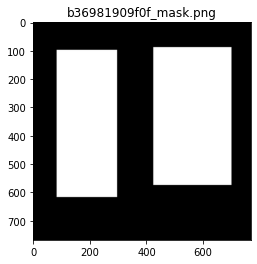

In [115]:
if convert_mask:
    mask_folder = glob('/kaggle/working/tmp/train/mask/*')
    print(f"\nMask Image length : {len(mask_folder)}\n") # 4294 -> box 있는 모든 이미지는 처리 됨.
    sample = mask_folder[0]
    plt.imshow(plt.imread(sample))
    plt.title(sample.split('/')[-1])
#'/kaggle/working/tmp/train/mask/b36981909f0f_mask.png'

In [116]:
name = sample.split('/')[-1].split('_')[0]
tmp = new_df[new_df['id'] == name + '_image']
boxes = tmp['boxes'].item()
boxes

"[{'x': 369.48674, 'y': 357.52212, 'width': 945.13278, 'height': 1890.26547}, {'x': 1880.99117, 'y': 322.12389, 'width': 1221.23877, 'height': 1769.9115}]"

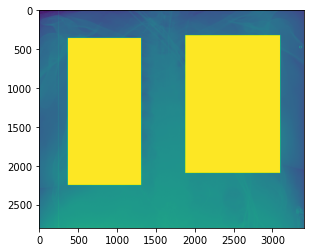

In [117]:
train_path = '/kaggle/input/siim-covid19-detection/train/'
path = train_path + tmp['StudyInstanceUID'].item()
for dirname, _, filename in os.walk(path):
    for file in filename:
        xray = read_xray(os.path.join(dirname, file))
        #im = resize(xray, size = study_size)
        for box in ast.literal_eval(boxes):
            x1, y1, x2, y2 = box['x'], box['y'], box['x']+box['width'], box['y']+box['height']
            x1 = int(x1)
            y1 = int(y1)
            x2 = int(x2)
            y2 = int(y2)
            cv2.rectangle(xray, (x1, y1), (x2, y2), (255, 255, 255), -1)
        plt.imshow(xray)

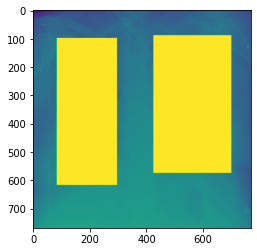

In [118]:
plt.imshow(resize(xray, size = study_size))

In [127]:
print(f"mask folder length:", len(glob(mask_dir+'*'))) # 4294 = box 존재하는 이미지는 모두 변환됨
mask_dir

mask folder length: 4294


'/kaggle/working/tmp/train/mask/'

In [129]:
!zip -r /kaggle/working/mask_image.zip $mask_dir

  adding: kaggle/working/tmp/train/mask/ (stored 0%)
  adding: kaggle/working/tmp/train/mask/b36981909f0f_mask.png (deflated 78%)
  adding: kaggle/working/tmp/train/mask/4afb6d501521_mask.png (deflated 85%)
  adding: kaggle/working/tmp/train/mask/018343ac5c25_mask.png (deflated 83%)
  adding: kaggle/working/tmp/train/mask/78298f509c7b_mask.png (deflated 83%)
  adding: kaggle/working/tmp/train/mask/0f0b5a304a47_mask.png (deflated 79%)
  adding: kaggle/working/tmp/train/mask/769d5c10878c_mask.png (deflated 75%)
  adding: kaggle/working/tmp/train/mask/88c17aa49561_mask.png (deflated 73%)
  adding: kaggle/working/tmp/train/mask/eb26cddff06a_mask.png (deflated 76%)
  adding: kaggle/working/tmp/train/mask/63ca42eab550_mask.png (deflated 82%)
  adding: kaggle/working/tmp/train/mask/d7bd07106cd1_mask.png (deflated 79%)
  adding: kaggle/working/tmp/train/mask/3287bfcd205c_mask.png (deflated 74%)
  adding: kaggle/working/tmp/train/mask/0b71b8e12551_mask.png (deflated 74%)
  adding: kaggle/workin

In [130]:
mask_meta_df = pd.DataFrame.from_dict({'study_id':study_ids, 'image_id':image_ids, 'dim0': dim0, 'dim1': dim1})
mask_meta_df.to_csv('mask_meta_df.csv', index=False)
mask_meta_df

,study_id,image_id,dim0,dim1
0,cd5dd5e6f3f5,d8ba599611e5,2336,2836
1,49358afcfb80,29b23a11d1e4,3488,4256
2,e4b50e7402c3,8174f49500a5,2330,2846
3,e4b50e7402c3,d54f6204b044,2330,2846
4,92aad2d01be8,d51cadde8626,3488,4256
...,...,...,...,...
6112,feffa20fac13,26979950fcc9,2544,3056
6113,485d4ccd3c0e,729eca7b4c1c,2539,3050
6114,59d10129bc08,d342f75ccb55,2320,2832
6115,e6ade0ee672e,0f0b5a304a47,2320,2832


In [ ]:
# 이렇게 약간의 데이터셋 변경하면 문제가 되진 않을까? 성능이 떨어지진 않을까?
# 그럼 기존 모델을 쓰면 된다.
# 아니면 앙상블을 해도 된다.

# 마스크 생성은 image_level box 에 기반하는데, 여기서 잘못된 annotating 은 제거하는 것이 낫다.

In [ ]:
#len(glob('/kaggle/working/tmp/train/study/*'))

In [ ]:
#!zip -r /kaggle/working/study_new_768.zip /kaggle/working/tmp/train/study 